# Setup 

In [1]:
from collections import Counter
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import statsmodels.formula.api as smf

In [5]:
import auto_ml

In [8]:
def analyze_accuracy(y_test, y_pred_prob, y_pred_class):
    naive_pred = [1 for i in range(len(y_pred_class))]
    
    ns_auc = roc_auc_score(y_test, naive_pred)
    md_auc = roc_auc_score(y_test, y_pred_prob)
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Model   : ROC AUC=%.3f' % (md_auc))
    
    cm = confusion_matrix(y_test, y_pred_class)
    sns.heatmap(cm, annot=True)
    plt.show()
    
    ns_fpr, ns_tpr, _ = roc_curve(y_test, naive_pred)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred_prob)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [9]:
def get_predictions(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    y_pred_class = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)
    y_pred_prob = [elem[1] for elem in y_pred_prob]
    
    return y_pred_class, y_pred_prob

In [10]:
def plot_calibration(y_test, y_prob):
    fop, mpv = calibration_curve(y_test,y_prob, n_bins=10, normalize=True)
    # plot perfectly calibrated
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot model reliability
    plt.plot(mpv, fop, marker='.')
    plt.show()

In [11]:
df = pd.read_csv("chess_king_rook_dataset.csv")

## Understanding Data

In [12]:
df.dtypes

white_king_file    object
white_king_rank     int64
white_rook_file    object
white_rook_rank     int64
black_king_file    object
black_king_rank     int64
result             object
dtype: object

In [13]:
df['white_king_rank'].unique(), df['white_rook_rank'].unique()

(array([1, 2, 3, 4], dtype=int64),
 array([3, 1, 2, 4, 5, 6, 7, 8], dtype=int64))

Should we keep the rank variable numeric? Seems more categorical (ie 1, 2, etc are row names, not a true continuous variable like height or weight)

In [14]:
df['result'].unique()

array(['draw', 'zero', 'one', 'two', 'three', 'four', 'five', 'six',
       'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve', 'thirteen',
       'fourteen', 'fifteen', 'sixteen'], dtype=object)

In [15]:
df.shape

(28056, 7)

draw is a draw, numbers are # of turns to a win

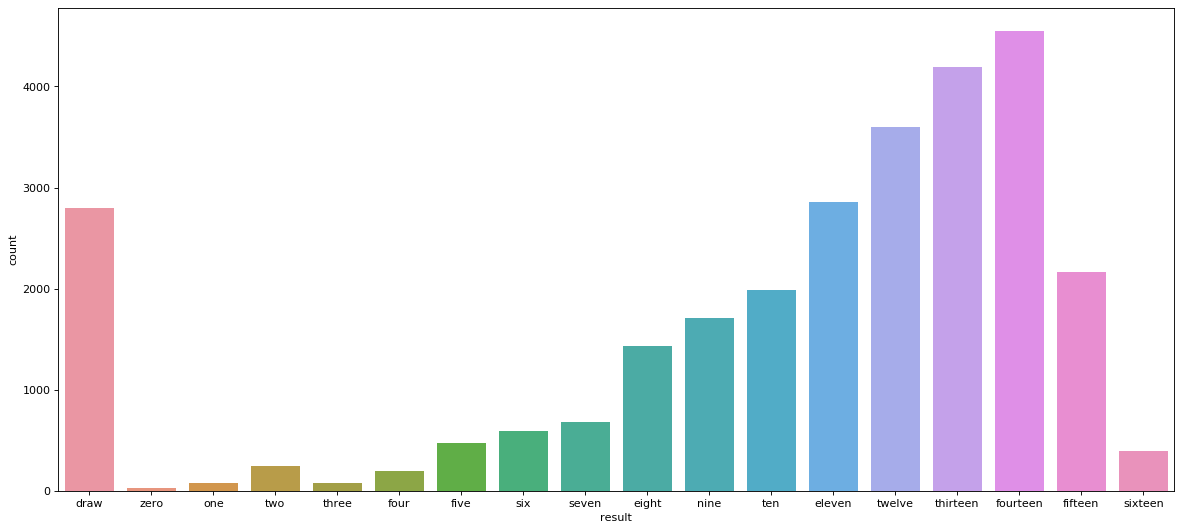

In [16]:
plt.figure(figsize=(18, 8), dpi=80)
sns.countplot(data=df, x='result')

In [17]:
# binary result fits with Santorini (draws aren't possible in that game)
df['win'] = df['result'] != 'draw'
df['win'] = df['win'].astype(int)

In [18]:
df.win.mean() #90%ish are wins

0.9003421727972626

## Create series of dummy variables for columns

In [19]:
for col in df.columns:
    if "rank" in col:
        df[col] = df[col].astype(str)

df.dtypes

white_king_file    object
white_king_rank    object
white_rook_file    object
white_rook_rank    object
black_king_file    object
black_king_rank    object
result             object
win                 int32
dtype: object

In [20]:
dummy_df = copy.deepcopy(df)
del dummy_df['result']

In [21]:
dummy_df = pd.get_dummies(dummy_df)
dummy_df['result'] = df['result']

In [22]:
dummy_df.head()

win  white_king_file_a  white_king_file_b  white_king_file_c  \
0    0                  1                  0                  0   
1    0                  1                  0                  0   
2    0                  1                  0                  0   
3    0                  1                  0                  0   
4    0                  1                  0                  0   

   white_king_file_d  white_king_rank_1  white_king_rank_2  white_king_rank_3  \
0                  0                  1                  0                  0   
1                  0                  1                  0                  0   
2                  0                  1                  0                  0   
3                  0                  1                  0                  0   
4                  0                  1                  0                  0   

   white_king_rank_4  white_rook_file_a  ...  black_king_file_h  \
0                  0                  0  ...                  0   
1                  0                  0  ...                  0   
2                  0                  0  ...                  0   
3                  0                  0  ...                  0   
4                  0                  0  ...                  0   

   black_king_rank_1  black_king_rank_2  black_king_rank_3  black_king_rank_4  \
0                  0                  1                  0                  0   
1                  0                  1                  0                  0   
2                  1                  0                  0                  0   
3                  0                  1                  0                  0   
4                  1                  0                  0                  0   

   black_king_rank_5  black_king_rank_6  black_king_rank_7  black_king_rank_8  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   result  
0    draw  
1    draw  
2    draw  
3    draw  
4    draw  

[5 rows x 42 columns]

Quick check: what variables are statisitcally significant?

In [14]:
formula_str = 'win ~ '
col_list = []
for col in df.columns:
    if col != 'result' and col != 'win':
        formula_str += col + ' + '
        col_list.append(col)
    
formula_str = formula_str[0:len(formula_str) - 3] # remove last plus sign    
print(formula_str)

probit_model = smf.probit(data = df, formula = formula_str).fit()
probit_model.summary()

win ~ white_king_file + white_king_rank + white_rook_file + white_rook_rank + black_king_file + black_king_rank
Optimization terminated successfully.
         Current function value: 0.312907
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                28056
Model:                         Probit   Df Residuals:                    28021
Method:                           MLE   Df Model:                           34
Date:                Sun, 06 Jun 2021   Pseudo R-squ.:                 0.03522
Time:                        11:15:35   Log-Likelihood:                -8778.9
converged:                       True   LL-Null:                       -9099.4
Covariance Type:            nonrobust   LLR p-value:                4.021e-113
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                2.1759      0.076     28.506      0.000       2.026       2.326
white_king_file[T.b]     0.0115      0.047      0.243      0.808      -0.081       0.105
white_king_file[T.c]     0.0212      0.047      0.451      0.652      -0.071       0.113
white_king_file[T.d]     0.0262      0.048      0.550      0.583      -0.067       0.120
white_king_rank[T.2]     0.0149      0.026      0.583      0.560      -0.035       0.065
white_king_rank[T.3]     0.0296      0.032      0.918      0.359      -0.034       0.093
white_king_rank[T.4]     0.0138      0.051      0.272      0.785      -0.086       0.113
white_rook_file[T.b]    -0.2029      0.047     -4.362      0.000      -0.294      -0.112
white_rook_file[T.c]    -0.1241      0.048     -2.605      0.009      -0.217      -0.031
white_rook_file[T.d]    -0.2131      0.047     -4.554      0.000      -0.305      -0.121
white_rook_file[T.e]    -0.3218      0.045     -7.128      0.000      -0.410      -0.233
white_rook_file[T.f]    -0.4753      0.044    -10.817      0.000      -0.561      -0.389
white_rook_file[T.g]    -0.5679      0.043    -13.123      0.000      -0.653      -0.483
white_rook_file[T.h]    -0.2872      0.045     -6.341      0.000      -0.376      -0.198
white_rook_rank[T.2]    -0.2224      0.045     -4.974      0.000      -0.310      -0.135
white_rook_rank[T.3]    -0.2362      0.045     -5.298      0.000      -0.324      -0.149
white_rook_rank[T.4]    -0.3213      0.044     -7.325      0.000      -0.407      -0.235
white_rook_rank[T.5]    -0.3485      0.044     -7.985      0.000      -0.434      -0.263
white_rook_rank[T.6]    -0.3285      0.044     -7.490      0.000      -0.414      -0.243
white_rook_rank[T.7]    -0.3031      0.044     -6.873      0.000      -0.389      -0.217
white_rook_rank[T.8]    -0.0067      0.047     -0.141      0.887      -0.100       0.086
black_king_file[T.b]    -0.2303      0.048     -4.840      0.000      -0.324      -0.137
black_king_file[T.c]    -0.2083      0.049     -4.214      0.000      -0.305      -0.111
black_king_file[T.d]    -0.2014      0.048     -4.196      0.000      -0.295      -0.107
black_king_file[T.e]    -0.2078      0.046     -4.517      0.000      -0.298      -0.118
black_king_file[T.f]    -0.2111      0.044     -4.781      0.000      -0.298      -0.125
black_king_file[T.g]    -0.2537      0.044     -5.829      0.000      -0.339      -0.168
black_king_file[T.h]     0.0306      0.045      0.673      0.501      -0.059       0.120
black_king_rank[T.2]    -0.2603      0.045     -5.830      0.000      -0.348      -0.173
black_king_rank[T.3]    -0.2373      0.044     -5.366      0.000      -0.324      -0.151
black_king_rank[T.4]    -0.2753      0.043     -6.357      0.000      -0.360      -0.190
black_king_rank[T.5]    -0.2972      0.043     -6.902      0.000      -0.382      -0.213
black_king_rank[T.6]    -0.3129      0.044     -7.181      0.000      -0.398      -0.228
black_king_rank[T.7]    -0.3370      

white king's ocation seem's meaningless, most of everything else is meaningful

Multinomial probit on result variable is also possible, but would have 17 different models, not very readable

# Sklearn - No Parameter Tuning, No Scaling

Won't have time to analyze individual boards in Santorini. Will need to rely on on predictions

## Data Setup

In [26]:
col_list = []
for col in dummy_df.columns:
    if col != 'win' and col != 'result':
        col_list.append(col)

X = dummy_df.loc[:, col_list]
y = dummy_df['win']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [16]:
Counter(y_test)

Counter({1: 5053, 0: 559})

Next piece will remain commented out. Don't need to scale binary variables. But good practice to do it anyway

In [17]:
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

## Model 1: Linear SVM

In [167]:
linear_svc = SVC(kernel='linear', random_state=0, probability = True)
y_pred_class, y_pred_prob = get_predictions(linear_svc, X_train, y_train, X_test)

No Skill: ROC AUC=0.500
Model   : ROC AUC=0.481


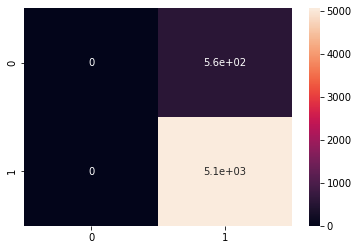

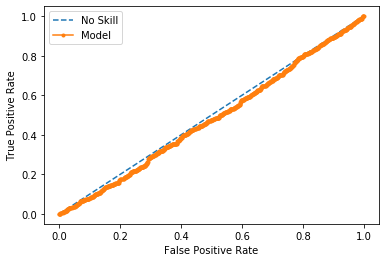

In [158]:
analyze_accuracy(y_test, y_pred_prob, y_pred_class)

SVM is worse than nothing!

# Model 2: Non-linear SVM

In [165]:
kernel_svc = SVC(kernel='rbf', gamma = 'auto', random_state=0, probability = True)
y_pred_class_rbf, y_pred_prob_rbf = get_predictions(kernel_svc, X_train, y_train, X_test)

No Skill: ROC AUC=0.500
Model   : ROC AUC=0.999


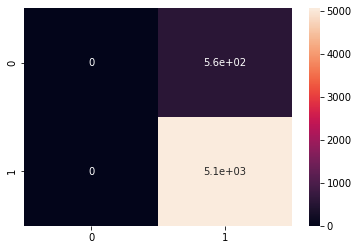

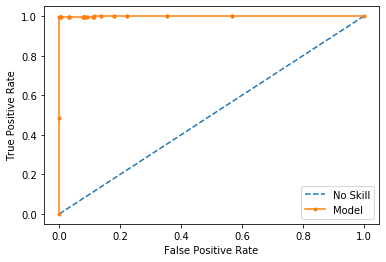

In [166]:
analyze_accuracy(y_test, y_pred_prob_rbf, y_pred_class_rbf)

What happened to the ROC curve? Separate note: model is still useless

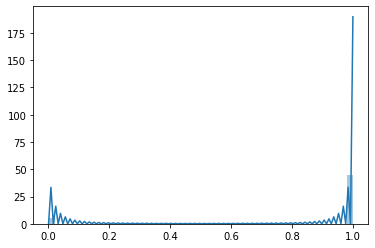

In [171]:
sns.distplot(y_pred_prob_rbf)

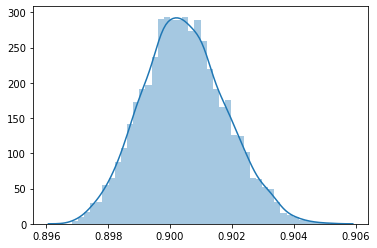

In [172]:
sns.distplot(y_pred_prob)

Kernel RBF predicts some low values. Linear RBF predicts ONLY high ones

## Model 3: Decision Trees - Bagging

In [22]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)

y_pred_class_rf, y_pred_prob_rf = get_predictions(rf_model, X_train, y_train, X_test)

No Skill: ROC AUC=0.500
Model   : ROC AUC=0.999


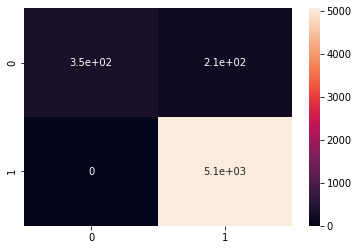

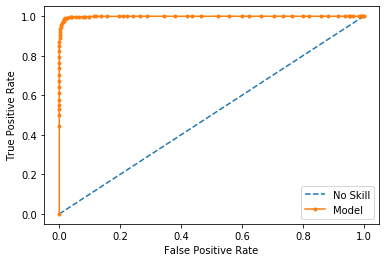

In [35]:
analyze_accuracy(y_test, y_pred_prob_rf, y_pred_class_rf)

Hey! Some correctly predicted 0s now!

## Model 4 - Decision Trees (Boosting)

In [27]:
from xgboost import XGBClassifier
xgb = XGBClassifier(booster='gbtree', random_state=0)

In [28]:
y_pred_class_xg, y_pred_prob_xg = get_predictions(xgb, X_train, y_train, X_test)

No Skill: ROC AUC=0.500
Model   : ROC AUC=1.000


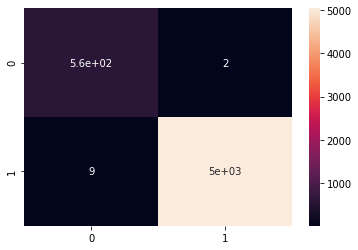

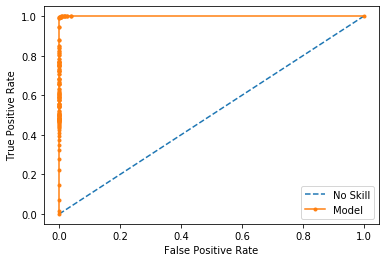

In [29]:
analyze_accuracy(y_test, y_pred_prob_xg, y_pred_class_xg)

Only 11 misses! Best model thus far. But I also want to look into parameter tuning

# Grid Search

Going to only look at kernel SVM since grid search takes very long

In [22]:
params = {'C': [10 ** n for n in range(-1,3)],
        'gamma' : [10 ** n for n in range(-2,1)],
        'kernel' : ['rbf']}
params

{'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1], 'kernel': ['rbf']}

In [23]:
grid_search_svc = GridSearchCV(estimator =SVC(random_state=0, probability = True),
                        param_grid = params,
                        cv = 4,
                        scoring = 'neg_log_loss',
                        n_jobs = -1,
                        verbose = 4)

In [24]:
y_pred_class_cv, y_pred_prob_cv = get_predictions(grid_search_svc, X_train, y_train, X_test)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 91.9min finished


No Skill: ROC AUC=0.500
Model   : ROC AUC=1.000


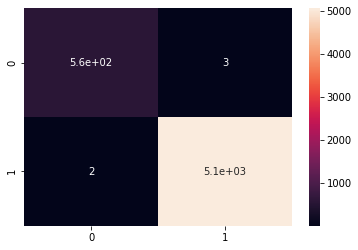

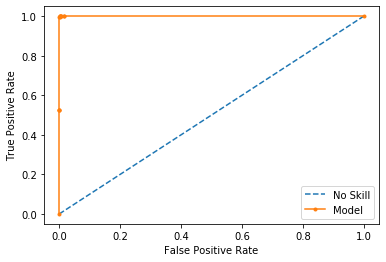

In [25]:
analyze_accuracy(y_test, y_pred_prob_cv, y_pred_class_cv)

Only 5 errors! But it took an hour and half to run

## Calibration

## Pre-Calibration

Classification is binary (in this case), did it pick the right group?
But we also might be interested in probability. What is the chance of a winning with this move?

Calibration means those percentages are accurate. For example, a move that gives a 70% chance of victory
should win about 70% of the time. If a win that shows a 70% chance of victory wins 99% of the time or 51% of
time, it would be an accurate prediction, but poorly calibrated

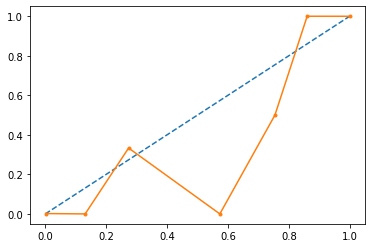

In [32]:
from sklearn.calibration import calibration_curve

plot_calibration(y_test, y_pred_prob_cv)

Doesn't look terribly well calibrated. Let's compare to some other models

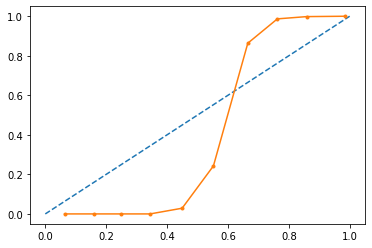

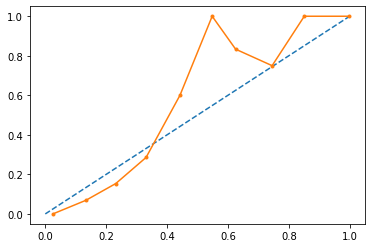

In [39]:
# Random Forest:
plot_calibration(y_test, y_pred_prob_rf)

#XG Boost
plot_calibration(y_test, y_pred_prob_xg)

XG Boost looks the best calibrated. But none are particularly great.

Two types of scaling
* Platt's scaling (i.e. sigmoid). Fits a logistic regression to predictions
* Monotonic regression (i.e. isotonic). Fits it to a piecewise constantly increasing model

In [23]:
rf_platt = CalibratedClassifierCV(rf_model, method = 'sigmoid')
rf_iso = CalibratedClassifierCV(rf_model, method = 'isotonic')

In [24]:
_ , pred_prob_platt = get_predictions(rf_platt, X_train, y_train, X_test)
_ , pred_prob_iso = get_predictions(rf_iso, X_train, y_train, X_test)

Original


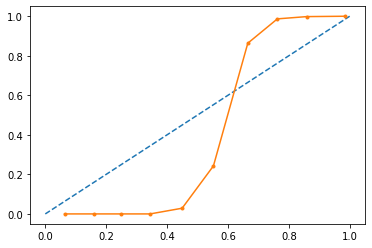

Platt Calibration


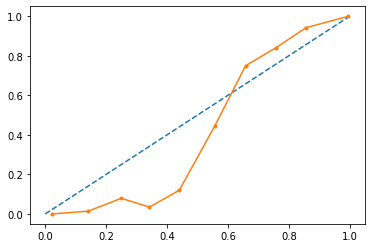

Isotonic Calibration


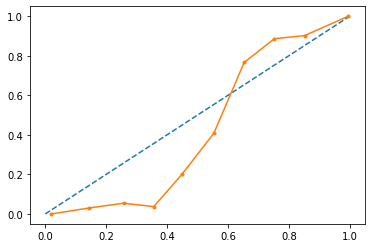

In [30]:
print("Original")
plot_calibration(y_test, y_pred_prob_rf)
print("Platt Calibration")
plot_calibration(y_test, pred_prob_platt)
print("Isotonic Calibration")
plot_calibration(y_test, pred_prob_iso)

Some noticeable change in calibrations

## Scaling - XG Boost

In [33]:
xg_platt = CalibratedClassifierCV(xgb, method = 'sigmoid')
xg_iso = CalibratedClassifierCV(xgb, method = 'isotonic')

In [34]:
_ , xg_prob_platt = get_predictions(xg_platt, X_train, y_train, X_test)
_ , xg_prob_iso = get_predictions(xg_iso, X_train, y_train, X_test)

Original


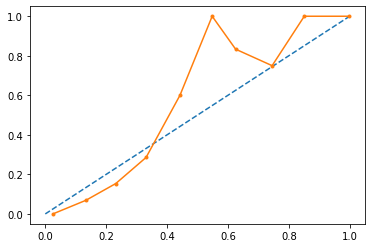

Platt Calibration


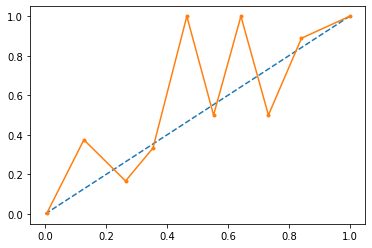

Isotonic Calibration


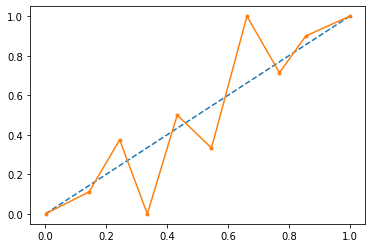

In [39]:
print("Original")
plot_calibration(y_test, y_pred_prob_xg)
print("Platt Calibration")
plot_calibration(y_test, xg_prob_platt)
print("Isotonic Calibration")
plot_calibration(y_test, xg_prob_iso)

Not really clear if that made it better

# Extentions 

The techniques aboves are probably sufficient for this dataset.
However, I don't care about predicting chess moves, I want this to inform the Santorini AI.
As such, I will try three more pieces that help the Santorini project, but aren't needed here:

* Bayesian Optimization (an improvement on grid search)
* Auto ML (not used in AI as far as I know, but worth using)
* Deep Neural Networks (the models actually used by game AI's like AlphaZero)

Note: The NN will be in a different file, since it requries separate usage in Anaconda

## Bayesian Optimization

In [49]:
opt = BayesSearchCV(
        estimator =XGBClassifier(booster='gbtree', random_state=0),
        search_spaces = {
            'max_depth': Integer(3, 10),
            'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
            'colsample_bytree': Real(0.5, 0.9, prior='uniform')},
        n_iter = 16,
        random_state = 0,
        cv = 3,
        n_jobs = -1,
        verbose = 4,
)

In [48]:
xg_opt_calib = CalibratedClassifierCV(opt, method = 'isotonic')

_ , bayes_opt_pred = get_predictions(xg_opt_calib, X_train, y_train, X_test)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.4s finished
C:\Users\18053\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.4s finished
C:\Users\18053\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished


Original


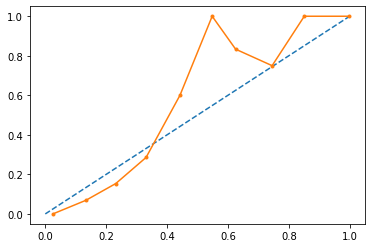

Isotonic Calibration


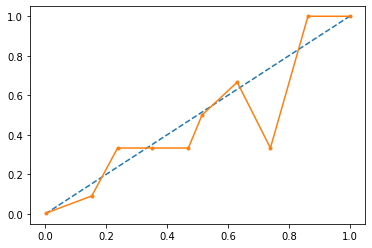

In [52]:
print("Original")
plot_calibration(y_test, y_pred_prob_xg)
print("Isotonic Calibration")
plot_calibration(y_test, bayes_opt_pred)

A bit awkward in the 70-80% range. Better elsewhere

In [54]:
# Side note: what were the best version of these hyperparmaters?
opt = BayesSearchCV(
        estimator =XGBClassifier(booster='gbtree', random_state=0),
        search_spaces = {
            'max_depth': Integer(3, 10),
            'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
            'colsample_bytree': Real(0.5, 0.9, prior='uniform')},
        n_iter = 16,
        random_state = 0,
        cv = 3,
        n_jobs = -1,
        verbose = 0,
)

opt.fit(X_train, y_train)
opt.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8886828062340487,
              gamma=1.2114921413252034e-06, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

# AutoML

The least interpretable model, but worth trying

In [28]:
from auto_ml import Predictor

column_descriptions = {
    'win': 'output',
}

ml_predictor = Predictor(type_of_estimator='classifier', column_descriptions=column_descriptions)

X_train['win'] = y_train.values

ml_predictor.train(X_train)

Welcome to auto_ml! We're about to go through and make sense of your data using machine learning, and give you a production-ready pipeline to get predictions with.

If you have any issues, or new feature ideas, let us know at http://auto.ml
You are running on version 2.9.10
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{'presort': False, 'learning_rate': 0.1, 'warm_start': True}
Running basic data cleaning


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Fitting DataFrameVectorizer
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{'presort': False, 'learning_rate': 0.1, 'warm_start': True}


********************************************************************************************
About to fit the pipeline for the model GradientBoostingClassifier to predict win
Started at:
2021-06-08 19:05:17
[1] random_holdout_set_from_training_data's score is: -0.092
[2] random_holdout_set_from_training_data's score is: -0.091


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarn

[3] random_holdout_set_from_training_data's score is: -0.09
[4] random_holdout_set_from_training_data's score is: -0.09
[5] random_holdout_set_from_training_data's score is: -0.089
[6] random_holdout_set_from_training_data's score is: -0.088
[7] random_holdout_set_from_training_data's score is: -0.087
[8] random_holdout_set_from_training_data's score is: -0.087


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarn

[9] random_holdout_set_from_training_data's score is: -0.086
[10] random_holdout_set_from_training_data's score is: -0.085
[11] random_holdout_set_from_training_data's score is: -0.085
[12] random_holdout_set_from_training_data's score is: -0.084
[13] random_holdout_set_from_training_data's score is: -0.083
[14] random_holdout_set_from_training_data's score is: -0.083
[15] random_holdout_set_from_training_data's score is: -0.082


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarn

[16] random_holdout_set_from_training_data's score is: -0.081
[17] random_holdout_set_from_training_data's score is: -0.08
[18] random_holdout_set_from_training_data's score is: -0.08
[19] random_holdout_set_from_training_data's score is: -0.08
[20] random_holdout_set_from_training_data's score is: -0.079
[21] random_holdout_set_from_training_data's score is: -0.079


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarn

[22] random_holdout_set_from_training_data's score is: -0.078
[23] random_holdout_set_from_training_data's score is: -0.078
[24] random_holdout_set_from_training_data's score is: -0.077
[25] random_holdout_set_from_training_data's score is: -0.076
[26] random_holdout_set_from_training_data's score is: -0.076


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarn

[27] random_holdout_set_from_training_data's score is: -0.075
[28] random_holdout_set_from_training_data's score is: -0.075
[29] random_holdout_set_from_training_data's score is: -0.075
[30] random_holdout_set_from_training_data's score is: -0.074
[31] random_holdout_set_from_training_data's score is: -0.074
[32] random_holdout_set_from_training_data's score is: -0.073

C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarn


[33] random_holdout_set_from_training_data's score is: -0.073
[34] random_holdout_set_from_training_data's score is: -0.072
[35] random_holdout_set_from_training_data's score is: -0.072
[36] random_holdout_set_from_training_data's score is: -0.072


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarn

[37] random_holdout_set_from_training_data's score is: -0.071
[38] random_holdout_set_from_training_data's score is: -0.07
[39] random_holdout_set_from_training_data's score is: -0.07
[40] random_holdout_set_from_training_data's score is: -0.07
[41] random_holdout_set_from_training_data's score is: -0.069


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarn

[42] random_holdout_set_from_training_data's score is: -0.069
[43] random_holdout_set_from_training_data's score is: -0.068
[44] random_holdout_set_from_training_data's score is: -0.068
[45] random_holdout_set_from_training_data's score is: -0.067
[46] random_holdout_set_from_training_data's score is: -0.067


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarn

[47] random_holdout_set_from_training_data's score is: -0.067
[48] random_holdout_set_from_training_data's score is: -0.066
[49] random_holdout_set_from_training_data's score is: -0.066
[50] random_holdout_set_from_training_data's score is: -0.065
[52] random_holdout_set_from_training_data's score is: -0.064


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarn

[54] random_holdout_set_from_training_data's score is: -0.063
[56] random_holdout_set_from_training_data's score is: -0.063
[58] random_holdout_set_from_training_data's score is: -0.062
[60] random_holdout_set_from_training_data's score is: -0.061


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarn

[62] random_holdout_set_from_training_data's score is: -0.061
[64] random_holdout_set_from_training_data's score is: -0.06
[66] random_holdout_set_from_training_data's score is: -0.06
[68] random_holdout_set_from_training_data's score is: -0.059


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarn

[70] random_holdout_set_from_training_data's score is: -0.059
[72] random_holdout_set_from_training_data's score is: -0.058
[74] random_holdout_set_from_training_data's score is: -0.058
[76] random_holdout_set_from_training_data's score is: -0.057


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarn

[78] random_holdout_set_from_training_data's score is: -0.057
[80] random_holdout_set_from_training_data's score is: -0.056
[82] random_holdout_set_from_training_data's score is: -0.056


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarn

[84] random_holdout_set_from_training_data's score is: -0.056
[86] random_holdout_set_from_training_data's score is: -0.055
[88] random_holdout_set_from_training_data's score is: -0.055


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarn

[90] random_holdout_set_from_training_data's score is: -0.054
[92] random_holdout_set_from_training_data's score is: -0.054
[94] random_holdout_set_from_training_data's score is: -0.054


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarn

[96] random_holdout_set_from_training_data's score is: -0.053
[98] random_holdout_set_from_training_data's score is: -0.053
[100] random_holdout_set_from_training_data's score is: -0.052


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[103] random_holdout_set_from_training_data's score is: -0.052
[106] random_holdout_set_from_training_data's score is: -0.051


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[109] random_holdout_set_from_training_data's score is: -0.05
[112] random_holdout_set_from_training_data's score is: -0.05
[115] random_holdout_set_from_training_data's score is: -0.049

C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



[118] random_holdout_set_from_training_data's score is: -0.048


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[121] random_holdout_set_from_training_data's score is: -0.048
[124] random_holdout_set_from_training_data's score is: -0.047


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[127] random_holdout_set_from_training_data's score is: -0.047
[130] random_holdout_set_from_training_data's score is: -0.046


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[133] random_holdout_set_from_training_data's score is: -0.046
[136] random_holdout_set_from_training_data's score is: -0.045
[139] random_holdout_set_from_training_data's score is: -0.045


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarn

[142] random_holdout_set_from_training_data's score is: -0.045
[145] random_holdout_set_from_training_data's score is: -0.044


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[148] random_holdout_set_from_training_data's score is: -0.044
[151] random_holdout_set_from_training_data's score is: -0.043


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[154] random_holdout_set_from_training_data's score is: -0.042
[157] random_holdout_set_from_training_data's score is: -0.042


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[160] random_holdout_set_from_training_data's score is: -0.041
[163] random_holdout_set_from_training_data's score is: -0.041


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[166] random_holdout_set_from_training_data's score is: -0.04
[169] random_holdout_set_from_training_data's score is: -0.04


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[172] random_holdout_set_from_training_data's score is: -0.039
[175] random_holdout_set_from_training_data's score is: -0.039


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[178] random_holdout_set_from_training_data's score is: -0.038
[181] random_holdout_set_from_training_data's score is: -0.038


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[184] random_holdout_set_from_training_data's score is: -0.037
[187] random_holdout_set_from_training_data's score is: -0.037


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[190] random_holdout_set_from_training_data's score is: -0.037
[193] random_holdout_set_from_training_data's score is: -0.036


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[196] random_holdout_set_from_training_data's score is: -0.036
[199] random_holdout_set_from_training_data's score is: -0.036


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[202] random_holdout_set_from_training_data's score is: -0.035
[205] random_holdout_set_from_training_data's score is: -0.035


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[208] random_holdout_set_from_training_data's score is: -0.035
[211] random_holdout_set_from_training_data's score is: -0.034


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[214] random_holdout_set_from_training_data's score is: -0.033
[217] random_holdout_set_from_training_data's score is: -0.032


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[220] random_holdout_set_from_training_data's score is: -0.032
[223] random_holdout_set_from_training_data's score is: -0.031


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[226] random_holdout_set_from_training_data's score is: -0.031
[229] random_holdout_set_from_training_data's score is: -0.03


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[232] random_holdout_set_from_training_data's score is: -0.03
[235] random_holdout_set_from_training_data's score is: -0.03


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[238] random_holdout_set_from_training_data's score is: -0.03
[241] random_holdout_set_from_training_data's score is: -0.029


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[244] random_holdout_set_from_training_data's score is: -0.029
[247] random_holdout_set_from_training_data's score is: -0.028


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[250] random_holdout_set_from_training_data's score is: -0.028
[255] random_holdout_set_from_training_data's score is: -0.028


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[260] random_holdout_set_from_training_data's score is: -0.027
[265] random_holdout_set_from_training_data's score is: -0.027

C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



[270] random_holdout_set_from_training_data's score is: -0.026


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[275] random_holdout_set_from_training_data's score is: -0.026


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[280] random_holdout_set_from_training_data's score is: -0.026
[285] random_holdout_set_from_training_data's score is: -0.025


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[290] random_holdout_set_from_training_data's score is: -0.025


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[295] random_holdout_set_from_training_data's score is: -0.024


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[300] random_holdout_set_from_training_data's score is: -0.024
[305] random_holdout_set_from_training_data's score is: -0.024


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[310] random_holdout_set_from_training_data's score is: -0.023


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[315] random_holdout_set_from_training_data's score is: -0.023


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[320] random_holdout_set_from_training_data's score is: -0.022


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[325] random_holdout_set_from_training_data's score is: -0.022


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[330] random_holdout_set_from_training_data's score is: -0.021


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[335] random_holdout_set_from_training_data's score is: -0.021


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[340] random_holdout_set_from_training_data's score is: -0.021


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[345] random_holdout_set_from_training_data's score is: -0.021


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[350] random_holdout_set_from_training_data's score is: -0.02


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[355] random_holdout_set_from_training_data's score is: -0.02


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[360] random_holdout_set_from_training_data's score is: -0.019


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[365] random_holdout_set_from_training_data's score is: -0.019


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[370] random_holdout_set_from_training_data's score is: -0.019


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[375] random_holdout_set_from_training_data's score is: -0.018


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[380] random_holdout_set_from_training_data's score is: -0.018


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[385] random_holdout_set_from_training_data's score is: -0.018


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[390] random_holdout_set_from_training_data's score is: -0.017


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[395] random_holdout_set_from_training_data's score is: -0.017


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[400] random_holdout_set_from_training_data's score is: -0.017


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[405] random_holdout_set_from_training_data's score is: -0.017


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[410] random_holdout_set_from_training_data's score is: -0.016


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[415] random_holdout_set_from_training_data's score is: -0.016


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[420] random_holdout_set_from_training_data's score is: -0.016


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[425] random_holdout_set_from_training_data's score is: -0.016


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[430] random_holdout_set_from_training_data's score is: -0.016


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[435] random_holdout_set_from_training_data's score is: -0.016


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[440] random_holdout_set_from_training_data's score is: -0.015


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[445] random_holdout_set_from_training_data's score is: -0.015


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[450] random_holdout_set_from_training_data's score is: -0.015


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[455] random_holdout_set_from_training_data's score is: -0.015


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[460] random_holdout_set_from_training_data's score is: -0.015


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[465] random_holdout_set_from_training_data's score is: -0.015


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[470] random_holdout_set_from_training_data's score is: -0.015


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[475] random_holdout_set_from_training_data's score is: -0.015


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[480] random_holdout_set_from_training_data's score is: -0.014


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[485] random_holdout_set_from_training_data's score is: -0.014


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[490] random_holdout_set_from_training_data's score is: -0.014


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[495] random_holdout_set_from_training_data's score is: -0.014


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[500] random_holdout_set_from_training_data's score is: -0.014


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[510] random_holdout_set_from_training_data's score is: -0.013


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[520] random_holdout_set_from_training_data's score is: -0.012


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[530] random_holdout_set_from_training_data's score is: -0.012


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[540] random_holdout_set_from_training_data's score is: -0.011


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[550] random_holdout_set_from_training_data's score is: -0.011


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[560] random_holdout_set_from_training_data's score is: -0.011


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[570] random_holdout_set_from_training_data's score is: -0.01


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[580] random_holdout_set_from_training_data's score is: -0.01


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[590] random_holdout_set_from_training_data's score is: -0.01


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[600] random_holdout_set_from_training_data's score is: -0.01


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[610] random_holdout_set_from_training_data's score is: -0.01


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[620] random_holdout_set_from_training_data's score is: -0.009


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[630] random_holdout_set_from_training_data's score is: -0.009


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[640] random_holdout_set_from_training_data's score is: -0.009


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[650] random_holdout_set_from_training_data's score is: -0.009


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[660] random_holdout_set_from_training_data's score is: -0.009


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[670] random_holdout_set_from_training_data's score is: -0.009


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[680] random_holdout_set_from_training_data's score is: -0.008


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[690] random_holdout_set_from_training_data's score is: -0.008


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[700] random_holdout_set_from_training_data's score is: -0.008


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[710] random_holdout_set_from_training_data's score is: -0.008


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[720] random_holdout_set_from_training_data's score is: -0.008


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[730] random_holdout_set_from_training_data's score is: -0.008


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[740] random_holdout_set_from_training_data's score is: -0.008


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[750] random_holdout_set_from_training_data's score is: -0.008


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[760] random_holdout_set_from_training_data's score is: -0.008


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[770] random_holdout_set_from_training_data's score is: -0.007


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[780] random_holdout_set_from_training_data's score is: -0.007


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[790] random_holdout_set_from_training_data's score is: -0.007


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[800] random_holdout_set_from_training_data's score is: -0.007


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[810] random_holdout_set_from_training_data's score is: -0.007


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[820] random_holdout_set_from_training_data's score is: -0.007


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[830] random_holdout_set_from_training_data's score is: -0.007


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[840] random_holdout_set_from_training_data's score is: -0.006


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[850] random_holdout_set_from_training_data's score is: -0.006


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[860] random_holdout_set_from_training_data's score is: -0.006


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[870] random_holdout_set_from_training_data's score is: -0.006


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[880] random_holdout_set_from_training_data's score is: -0.006


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[890] random_holdout_set_from_training_data's score is: -0.006


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[900] random_holdout_set_from_training_data's score is: -0.006


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[910] random_holdout_set_from_training_data's score is: -0.006


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[920] random_holdout_set_from_training_data's score is: -0.006


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[930] random_holdout_set_from_training_data's score is: -0.006


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[940] random_holdout_set_from_training_data's score is: -0.006


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[950] random_holdout_set_from_training_data's score is: -0.005


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[960] random_holdout_set_from_training_data's score is: -0.005


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[970] random_holdout_set_from_training_data's score is: -0.005


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[980] random_holdout_set_from_training_data's score is: -0.005


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[990] random_holdout_set_from_training_data's score is: -0.005


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1000] random_holdout_set_from_training_data's score is: -0.005


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1020] random_holdout_set_from_training_data's score is: -0.005


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1040] random_holdout_set_from_training_data's score is: -0.005


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1060] random_holdout_set_from_training_data's score is: -0.005


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1080] random_holdout_set_from_training_data's score is: -0.005


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1100] random_holdout_set_from_training_data's score is: -0.005


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1120] random_holdout_set_from_training_data's score is: -0.005


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1140] random_holdout_set_from_training_data's score is: -0.004


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1160] random_holdout_set_from_training_data's score is: -0.004


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1180] random_holdout_set_from_training_data's score is: -0.004


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1200] random_holdout_set_from_training_data's score is: -0.004


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1220] random_holdout_set_from_training_data's score is: -0.004


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1240] random_holdout_set_from_training_data's score is: -0.004


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1260] random_holdout_set_from_training_data's score is: -0.004


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1280] random_holdout_set_from_training_data's score is: -0.004


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1300] random_holdout_set_from_training_data's score is: -0.004


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1320] random_holdout_set_from_training_data's score is: -0.004


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1340] random_holdout_set_from_training_data's score is: -0.004


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1360] random_holdout_set_from_training_data's score is: -0.004


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1380] random_holdout_set_from_training_data's score is: -0.004


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1400] random_holdout_set_from_training_data's score is: -0.004


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1420] random_holdout_set_from_training_data's score is: -0.004


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1440] random_holdout_set_from_training_data's score is: -0.004


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1460] random_holdout_set_from_training_data's score is: -0.004


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1480] random_holdout_set_from_training_data's score is: -0.004


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1500] random_holdout_set_from_training_data's score is: -0.004


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1520] random_holdout_set_from_training_data's score is: -0.003


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1540] random_holdout_set_from_training_data's score is: -0.003


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1560] random_holdout_set_from_training_data's score is: -0.003


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1580] random_holdout_set_from_training_data's score is: -0.003


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1600] random_holdout_set_from_training_data's score is: -0.003


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1620] random_holdout_set_from_training_data's score is: -0.003


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1640] random_holdout_set_from_training_data's score is: -0.003


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1660] random_holdout_set_from_training_data's score is: -0.003


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1680] random_holdout_set_from_training_data's score is: -0.003


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1700] random_holdout_set_from_training_data's score is: -0.003


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1720] random_holdout_set_from_training_data's score is: -0.003


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1740] random_holdout_set_from_training_data's score is: -0.003


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1760] random_holdout_set_from_training_data's score is: -0.003


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1780] random_holdout_set_from_training_data's score is: -0.003


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1800] random_holdout_set_from_training_data's score is: -0.003


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1820] random_holdout_set_from_training_data's score is: -0.003


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1840] random_holdout_set_from_training_data's score is: -0.003


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1860] random_holdout_set_from_training_data's score is: -0.003


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1880] random_holdout_set_from_training_data's score is: -0.003


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1900] random_holdout_set_from_training_data's score is: -0.003


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1920] random_holdout_set_from_training_data's score is: -0.003


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1940] random_holdout_set_from_training_data's score is: -0.003


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1960] random_holdout_set_from_training_data's score is: -0.003


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[1980] random_holdout_set_from_training_data's score is: -0.003


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[2000] random_holdout_set_from_training_data's score is: -0.003


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[2100] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[2200] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[2300] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[2400] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[2500] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[2600] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[2700] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[2800] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[2900] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[3000] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[3100] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[3200] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[3300] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[3400] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[3500] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[3600] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[3700] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[3800] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[3900] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[4000] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[4100] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[4200] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[4300] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[4400] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[4500] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[4600] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[4700] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[4800] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[4900] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[5000] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[5100] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[5200] random_holdout_set_from_training_data's score is: -0.002


C:\Users\18053\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


[5300] random_holdout_set_from_training_data's score is: -0.002
The number of estimators that were the best for this training dataset: 3300
The best score on the holdout set: -0.0016903324679769783
Finished training the pipeline!
Total training time:
0:03:46


Here are the results from our GradientBoostingClassifier
predicting win
Calculating feature responses, for advanced analytics.
The printed list will only contain at most the top 100 features.
+----+-------------------+--------------+---------+-------------------+-------------------+-----------+-----------+-----------+-----------+
|    | Feature Name      |   Importance |   Delta |   FR_Decrementing |   FR_Incrementing |   FRD_abs |   FRI_abs |   FRD_MAD |   FRI_MAD |
|----+-------------------+--------------+---------+-------------------+-------------------+-----------+-----------+-----------+-----------|
|  7 | white_king_rank_4 |       0.0003 |  0.1134 |            0.0000 |            0.0000 |    0.0000 |    0.0000 |    0.0000 |

C:\Users\18053\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


In [29]:
ml_predictor.score(X_test, y_test)

Here is our brier-score-loss, which is the default value we optimized for while training, and is the value returned from .score() unless you requested a custom scoring metric
It is a measure of how close the PROBABILITY predictions are.
0.0015

Here is the trained estimator's overall accuracy (when it predicts a label, how frequently is that the correct label?)
99.8%

Here is a confusion matrix showing predictions vs. actuals by label:
Predicted >    0     1   All
v Actual v                  
0            554     5   559
1              9  5044  5053
All          563  5049  5612

Here is predictive value by class:
Class:  1 = 0.9990097048920579
Class:  0 = 0.9840142095914742
+---------------------------------+-----------------------------------+--------------------------------+
| Bucket Edges                    |   Predicted Probability Of Bucket |   Actual Probability of Bucket |
|---------------------------------+-----------------------------------+--------------------------------|
| 

-0.0015169759853195567